In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ( precision_recall_fscore_support,roc_auc_score, 
                             average_precision_score, cohen_kappa_score
                            )

from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize

## Loading the dataset

In [2]:
data = pd.read_csv('seed_dataset_csv.csv')

In [3]:
data.head(10)

,v135,v2,v2602,v2600,v7,r135,r2,r2602,r2600,r7,base135,base2,base2602,base2600,base7,label
0,431,632,335,656,400,-85,106,-79,10,-36,486,563,366,713,344,cleanair
1,434,641,339,655,406,-82,115,-75,9,-30,486,563,366,713,344,cleanair
2,433,648,342,660,409,-83,122,-72,14,-27,486,563,366,713,344,cleanair
3,431,640,343,661,411,-85,114,-71,15,-25,486,563,366,713,344,cleanair
4,428,635,347,661,423,-88,109,-67,15,-13,486,563,366,713,344,cleanair
5,429,633,353,658,434,-87,107,-61,12,-2,486,563,366,713,344,cleanair
6,429,626,362,656,437,-87,100,-52,10,1,486,563,366,713,344,cleanair
7,422,627,357,652,438,-94,101,-57,6,2,486,563,366,713,344,cleanair
8,427,628,357,653,443,-89,102,-57,7,7,486,563,366,713,344,cleanair
9,428,632,357,657,445,-88,106,-57,11,9,486,563,366,713,344,cleanair


In [4]:
print(f'Unique labels: {data["label"].unique()}, Freuquency of each class : {data["label"].value_counts()}')

Unique labels: ['cleanair' 'pepper' 'pepperPapaya'], Freuquency of each class : label
cleanair        750
pepper          750
pepperPapaya    750
Name: count, dtype: int64


## Feature Engineering

In [5]:
features = [
"r135","r2","r2602","r2600","r7",
"v135","v2","v2602","v2600","v7",
"base135","base2","base2602","base2600","base7"
]

y = data["label"].to_numpy()
X = data[features].to_numpy()

### Encoding the labels
Converting the labels from string to numerical format since our machine learning model expects the data to be in the form of numerical values

In [6]:
le = LabelEncoder()
data["label_id"] = le.fit_transform(data["label"])

In [7]:
label_map = dict(zip(le.transform(le.classes_), le.classes_))
print("Label map (id -> name):", label_map)

Label map (id -> name): {np.int64(0): 'cleanair', np.int64(1): 'pepper', np.int64(2): 'pepperPapaya'}


In [8]:
y = data["label_id"].to_numpy()

### Ratios
for sensor reading that are close to zero in relative mode they are replaced with epsilon value to avoid `ZeroDivision` Error

In [9]:
eps = 1e-6
data["ratio_2602_2600"] = data["r2602"] / (data["r2600"].replace(0, eps))
data["ratio_2_7"] = data["r2"] / (data["r7"].replace(0, eps))
data["ratio_135_2"] = data["r135"] / (data["r2"].replace(0, eps))

### Rolling mean/std over window=3 on relative channels

In [10]:
rel_cols = ["r135","r2","r2602","r2600","r7"]
for c in rel_cols:
    data[f"{c}_m3"] = data[c].rolling(3, min_periods=1).mean()
    data[f"{c}_s3"] = data[c].rolling(3, min_periods=1).std().fillna(0)

### Deltas to baseline on absolute channels

In [11]:
abs_base_pairs = [("v135","base135"),("v2","base2"),("v2602","base2602"),("v2600","base2600"),("v7","base7")]
for c, b in abs_base_pairs:
    data[f"{c}_delta"] = data[c] - data[b]

### updating features

In [12]:
extra = (
["ratio_2602_2600","ratio_2_7","ratio_135_2"]
+ [f"{c}_m3" for c in rel_cols]
+ [f"{c}_s3" for c in rel_cols]
+ [f"{c}_delta" for c, b in abs_base_pairs]
)
features = features + extra

In [13]:
X = data[features].to_numpy()
y = data["label"].to_numpy()

In [14]:
# sanity check
print(len(features), features[:10])

data[extra].head()

33 ['r135', 'r2', 'r2602', 'r2600', 'r7', 'v135', 'v2', 'v2602', 'v2600', 'v7']


,ratio_2602_2600,ratio_2_7,ratio_135_2,r135_m3,r2_m3,r2602_m3,r2600_m3,r7_m3,r135_s3,r2_s3,r2602_s3,r2600_s3,r7_s3,v135_delta,v2_delta,v2602_delta,v2600_delta,v7_delta
0,-7.900000,-2.944444,-0.801887,-85.000000,106.000000,-79.000000,10.000000,-36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-55,69,-31,-57,56
1,-8.333333,-3.833333,-0.713043,-83.500000,110.500000,-77.000000,9.500000,-33.000000,2.121320,6.363961,2.828427,0.707107,4.242641,-52,78,-27,-58,62
2,-5.142857,-4.518519,-0.680328,-83.333333,114.333333,-75.333333,11.000000,-31.000000,1.527525,8.020806,3.511885,2.645751,4.582576,-53,85,-24,-53,65
3,-4.733333,-4.560000,-0.745614,-83.333333,117.000000,-72.666667,12.666667,-27.333333,1.527525,4.358899,2.081666,3.214550,2.516611,-55,77,-23,-52,67
4,-4.466667,-8.384615,-0.807339,-85.333333,115.000000,-70.000000,14.666667,-21.666667,2.516611,6.557439,2.645751,0.577350,7.571878,-58,72,-19,-52,79


## Splitting the dataset
Before doing that we must shuffle the data as well since the data has been grouped together by classess

In [15]:
data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

In [16]:
data_shuffled = data_shuffled.replace([np.inf, -np.inf], np.nan).fillna(0)

In [17]:
X = data_shuffled[features].to_numpy()
y = data_shuffled["label_id"].to_numpy()

In [18]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
                                                                X, y, test_size=0.20, stratify=y, random_state=42
                                                            )

In [19]:
X_train, X_val, y_train, y_val = train_test_split(
                                                    X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42
                                                 )

In [20]:
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train sample rows:\n", X_train[:3])
print("Val sample rows:\n", X_val[:3])
print("Test sample rows:\n", X_test[:3])

Train: (1440, 33) Val: (360, 33) Test: (450, 33)
Train sample rows:
 [[ 7.30000000e+01  1.70000000e+01  8.50000000e+01 -2.41000000e+02
  -1.00000000e+00  2.63000000e+02  4.47000000e+02  2.92000000e+02
   3.48000000e+02  2.92000000e+02  1.90000000e+02  4.30000000e+02
   2.07000000e+02  5.89000000e+02  2.93000000e+02 -3.52697095e-01
  -1.70000000e+01  4.29411765e+00  7.13333333e+01  1.63333333e+01
   8.36666667e+01 -2.36333333e+02 -4.33333333e+00  1.52752523e+00
   4.04145188e+00  2.30940108e+00  4.50924975e+00  8.50490055e+00
   7.30000000e+01  1.70000000e+01  8.50000000e+01 -2.41000000e+02
  -1.00000000e+00]
 [ 2.10000000e+01 -1.00000000e+00  1.39000000e+02 -2.40000000e+02
   1.80000000e+01  3.19000000e+02  4.37000000e+02  3.12000000e+02
   2.13000000e+02  3.26000000e+02  2.98000000e+02  4.38000000e+02
   1.73000000e+02  4.53000000e+02  3.08000000e+02 -5.79166667e-01
  -5.55555556e-02 -2.10000000e+01  1.96666667e+01  2.63333333e+01
   1.50000000e+02 -2.33000000e+02 -3.66666667e+00  7.0

## Model Training

In [21]:
model = XGBClassifier(
                        n_estimators=300,
                        learning_rate=0.05,
                        max_depth=4,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        eval_metric="mlogloss",
                        random_state=42
                     )
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [26]:
eval_set = [(X_train, y_train), (X_val, y_val)]
model_curve = XGBClassifier(
n_estimators=500, learning_rate=0.05, max_depth=4,
subsample=0.8, colsample_bytree=0.8, eval_metric="mlogloss", random_state=42
)
model_curve.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

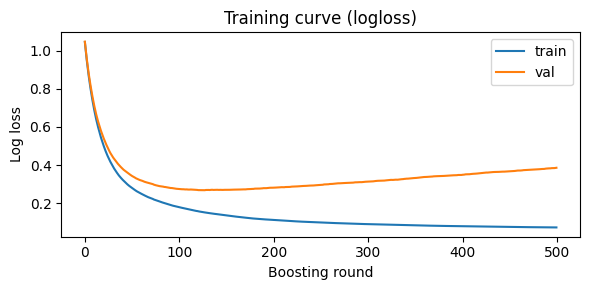

In [28]:
results = model_curve.evals_result()
plt.figure(figsize=(6,3))
plt.plot(results["validation_0"]["mlogloss"], label="train")
plt.plot(results["validation_1"]["mlogloss"], label="val")
plt.xlabel("Boosting round"); plt.ylabel("Log loss")
plt.title("Training curve (logloss)"); plt.legend(); plt.tight_layout(); plt.show()

### Validating

In [23]:
y_val_pred = model.predict(X_val)
print("Validation accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=3))
print("Val confusion:\n", confusion_matrix(y_val, y_val_pred))

Validation accuracy: 0.8416666666666667
              precision    recall  f1-score   support

           0      0.779     0.733     0.755       120
           1      0.748     0.792     0.769       120
           2      1.000     1.000     1.000       120

    accuracy                          0.842       360
   macro avg      0.842     0.842     0.842       360
weighted avg      0.842     0.842     0.842       360

Val confusion:
 [[ 88  32   0]
 [ 25  95   0]
 [  0   0 120]]


### Testing 

In [24]:
y_test_pred = model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))
print("Test confusion:\n", confusion_matrix(y_test, y_test_pred))

Test accuracy: 0.8266666666666667
              precision    recall  f1-score   support

           0      0.728     0.767     0.747       150
           1      0.754     0.713     0.733       150
           2      1.000     1.000     1.000       150

    accuracy                          0.827       450
   macro avg      0.827     0.827     0.827       450
weighted avg      0.827     0.827     0.827       450

Test confusion:
 [[115  35   0]
 [ 43 107   0]
 [  0   0 150]]


## Accuracy Metrics

In [32]:
# Create the ID-to-name mapping from your LabelEncoder
id_to_name = dict(zip(le.transform(le.classes_), le.classes_))
print("Label mapping:", id_to_name)

Label mapping: {np.int64(0): 'cleanair', np.int64(1): 'pepper', np.int64(2): 'pepperPapaya'}


In [34]:
def eval_split(model, X, y, split_name="Test", id_to_name=None):
    y_pred  = model.predict(X)
    y_proba = model.predict_proba(X) if hasattr(model, "predict_proba") else None

    # Basic metrics
    acc = accuracy_score(y, y_pred)
    print(f"{split_name} accuracy: {acc:.4f}\n")
    print(f"{split_name} classification report:\n{classification_report(y, y_pred, target_names=[id_to_name[i] for i in sorted(np.unique(y))] if id_to_name else None, digits=3)}")
    print(f"{split_name} confusion matrix:\n{confusion_matrix(y, y_pred)}\n")

    p, r, f1, _ = precision_recall_fscore_support(y, y_pred, average="macro", zero_division=0)
    print(f"{split_name} macro metrics -> precision: {p:.3f}, recall: {r:.3f}, f1: {f1:.3f}")

    kappa = cohen_kappa_score(y, y_pred)
    print(f"{split_name} Cohen's kappa: {kappa:.3f}")

    # ROC–AUC and PR–AUC (OvR) if probabilities available
    if y_proba is not None:
        classes = np.unique(y)
        y_bin = label_binarize(y, classes=classes)
        proba = y_proba if y_proba.shape[1] == len(classes) else np.hstack([1 - y_proba, y_proba])
        try:
            roc_macro = roc_auc_score(y_bin, proba, average="macro", multi_class="ovr")
            pr_macro  = average_precision_score(y_bin, proba, average="macro")
            print(f"{split_name} ROC–AUC (macro, OvR): {roc_macro:.3f}")
            print(f"{split_name} PR–AUC  (macro): {pr_macro:.3f}")
        except Exception as e:
            print(f"{split_name} AUC metrics unavailable: {e}")
    else:
        print(f"{split_name} AUC metrics skipped (no predict_proba).")

eval_split(model, X_val, y_val, split_name="Validation", id_to_name=id_to_name)
eval_split(model, X_test, y_test, split_name="Test", id_to_name=id_to_name)

Validation accuracy: 0.8417

Validation classification report:
              precision    recall  f1-score   support

    cleanair      0.779     0.733     0.755       120
      pepper      0.748     0.792     0.769       120
pepperPapaya      1.000     1.000     1.000       120

    accuracy                          0.842       360
   macro avg      0.842     0.842     0.842       360
weighted avg      0.842     0.842     0.842       360

Validation confusion matrix:
[[ 88  32   0]
 [ 25  95   0]
 [  0   0 120]]

Validation macro metrics -> precision: 0.842, recall: 0.842, f1: 0.842
Validation Cohen's kappa: 0.762
Validation ROC–AUC (macro, OvR): 0.960
Validation PR–AUC  (macro): 0.928
Test accuracy: 0.8267

Test classification report:
              precision    recall  f1-score   support

    cleanair      0.728     0.767     0.747       150
      pepper      0.754     0.713     0.733       150
pepperPapaya      1.000     1.000     1.000       150

    accuracy                       